In [13]:
import glob
import itertools
import math
import numpy as np
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset # module to open netcdf
import os
import pylab
import sys  #module to get external varaibles
import scipy.signal
import time

loc="/data/igcmg/database/grids"
os.chdir(loc)
os.getcwd()
file2read1 = Dataset('ORCA2.3_grid.nc','r')
area = np.array(file2read1.variables['area'])

sys.path.insert(0, "/ccc/cont003/home/gen7403/estellav/Python/Tools")
import corr_VEP as corr
import Diags_VEP as Diags

In [71]:
Models = []


Models.append({
              'name': 'CM61-LR-nudg-r8-2DERS-m',
              'label':'Nudg_SST_r8',
              'yr0':1900,
              'yr1':2010,
              'ts0':0,
              'ts1':110*12,
              'TS':'TS_MO',
              'color':'magenta',
              'ls':'-',
              'lw':2,
              'dir':'/ccc/store/cont003/thredds/estellav/IPSLCM6/DEVT/historical/'})
Models.append({
              'name': 'CM61-LR-nudg-r9-2DERS-m',
              'label':'Nudg_SST_r9',
              'yr0':1900,
              'yr1':1950,
              'ts0':0,
              'ts1':50*12,
              'TS':'TS_MO',
              'color':'magenta',
              'ls':'--',
              'lw':2,
              'dir':'/ccc/store/cont003/thredds/estellav/IPSLCM6/DEVT/historical/'})

Models.append({
              'name': 'CM61-LR-nudgSSTS-r1-2DERS-m',
              'label':'Nudg_60NS_r1',
              'yr0':1900,
              'yr1':2010,
              'ts0':0,
              'ts1':110*12,
              'TS':'TS_MO',
              'color':'blue',
              'ls':'-',
              'lw':2,
              'dir':'/ccc/store/cont003/thredds/estellav/IPSLCM6/DEVT/historical/'})

Models.append({
              'name': 'CM61-LR-nudgSSTS-r7-2DERS-m',
              'label':'Nudg_60NS_r7',
              'yr0':1900,
              'yr1':1990,
              'ts0':0,
              'ts1':90*12,
              'TS':'TS_MO',
              'color':'blue',
              'ls':'--',
              'lw':2,
              'dir':'/ccc/store/cont003/thredds/estellav/IPSLCM6/DEVT/historical/'})

Models.append({
              'name': 'CM61-LR-nudgSSTS-r8-2DERS-m',
              'label':'Nudg_60NS_r8',
              'yr0':1900,
              'yr1':2010,
              'ts0':0,
              'ts1':110*12,
              'TS':'TS_MO',
              'color':'blue',
              'ls':':',
              'lw':2,
              'dir':'/ccc/store/cont003/thredds/estellav/IPSLCM6/DEVT/historical/'})

Models.append({
              'name': 'CM61-LR-nudgSSTS2-r1-2DERS-m',
              'label':'Nudg_60NSFDSmsk_r1',
              'yr0':1900,
              'yr1':1990,
              'ts0':0,
              'ts1':90*12,
              'TS':'TS_MO',
              'color':'red',
              'ls':'-',
              'lw':2,
              'dir':'/ccc/store/cont003/thredds/estellav/IPSLCM6/DEVT/historical/'})

Models.append({
              'name': 'CM61-LR-nudgSSTS2-r7-2DERS-m',
              'label':'Nudg_60NSFDSmsk_r7',
              'yr0':1900,
              'yr1':1990,
              'ts0':0,
              'ts1':90*12,
              'TS':'TS_MO',
              'color':'red',
              'ls':'--',
              'lw':2,
              'dir':'/ccc/store/cont003/thredds/estellav/IPSLCM6/DEVT/historical/'})

Models.append({
              'name': 'CM61-LR-nudgSSTS2-r8-2DERS-m',
              'label':'Nudg_60NSFDSmsk_r8',
              'yr0':1900,
              'yr1':1990,
              'ts0':0,
              'ts1':90*12,
              'TS':'TS_MO',
              'color':'red',
              'ls':':',
              'lw':2,
              'dir':'/ccc/store/cont003/thredds/estellav/IPSLCM6/DEVT/historical/'})

nmodels=8
ntarget=7

In [58]:
loc="/data/igcmg/database/grids"
os.chdir(loc)
os.getcwd()
file2read1 = Dataset('eORCA1.2_mesh_mask_atl.nc','r')
Atl_Mask = np.array(file2read1.variables['tmask3Datl'])

file2read1 = Dataset('eORCA1.2_grid.nc','r')
area = np.array(file2read1.variables['area'])
lon = np.array(file2read1.variables['lon'])
lat = np.array(file2read1.variables['lat'])
Aarea = np.concatenate((area[np.newaxis,:,: ], area[np.newaxis,:,: ]), axis=0)
for i in range(108):
    Aarea = np.concatenate((Aarea, area[np.newaxis,:,: ]), axis=0)
    

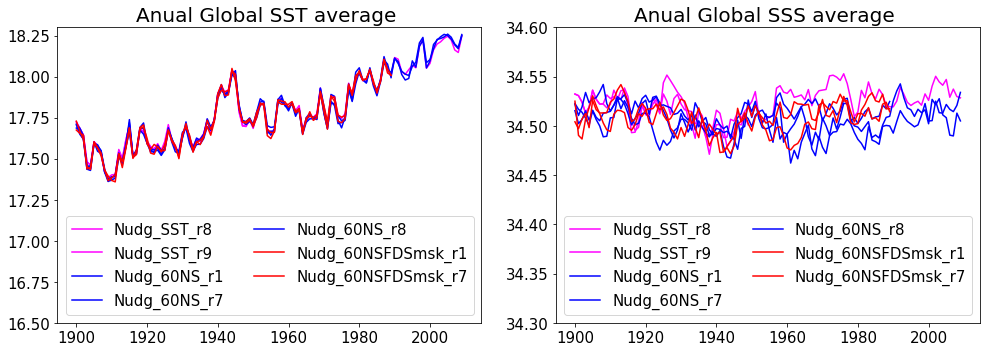

In [59]:
#Average = np.zeros((nmodels,Aarea.shape[1],Aarea.shape[2]))
plt.close()
fig, axes = plt.subplots(1,2,figsize=(2*7,5))
for imodel in range(nmodels):        
    dir1 = Models[imodel]['dir']+Models[imodel]['name']+'/OCE/Analyse/'+Models[imodel]['TS']
    os.chdir(dir1)
    file1 = glob.glob('*_tos.nc')
    
    f = Dataset(file1[0],'r')
    for time in range(0,Models[imodel]['yr1']-Models[imodel]['yr0']):
        tab=np.array(f.variables['tos'][Models[imodel]['ts0']+time*12:Models[imodel]['ts0']+12*(time+1),:,:])
        mask_tab=np.zeros((tab.shape[0],tab.shape[1],tab.shape[2]))
        mask_tab[ma.where(tab>1.e10)]=1. 
        tab_masked=ma.masked_where(mask_tab ==1., tab)
        tab_masked_temp=np.reshape(tab_masked,(12,tab_masked.shape[0]/12,tab_masked.shape[1],tab_masked.shape[2]),order='F')
        tab_masked_ann=ma.average(tab_masked_temp,axis=0)
    
        if time ==0:
            Average = ma.average(tab_masked_ann[:,:,:], axis=(1,2), weights = Aarea[:1,:,:])
        else:
            Average = ma.concatenate([Average, ma.average(tab_masked_ann[:,:,:], axis=(1,2), weights =Aarea[:1,:,:])], axis=0)
    
    axes[0].plot(np.arange(Models[imodel]['yr0'], Models[imodel]['yr1']),Average,color =Models[imodel]['color'], label=Models[imodel]['label']  )
    

    
    file1 = glob.glob('*_sos.nc')
    
    f = Dataset(file1[0],'r')
    for time in range(0,Models[imodel]['yr1']-Models[imodel]['yr0']):
        tab=np.array(f.variables['sos'][Models[imodel]['ts0']+time*12:Models[imodel]['ts0']+12*(time+1),:,:])
        mask_tab=np.zeros((tab.shape[0],tab.shape[1],tab.shape[2]))
        mask_tab[ma.where(tab>1.e10)]=1. 
        tab_masked=ma.masked_where(mask_tab ==1., tab)
        tab_masked_temp=np.reshape(tab_masked,(12,tab_masked.shape[0]/12,tab_masked.shape[1],tab_masked.shape[2]),order='F')
        tab_masked_ann=ma.average(tab_masked_temp,axis=0)
    
        if time ==0:
            Average = ma.average(tab_masked_ann[:,:,:], axis=(1,2), weights = Aarea[:1,:,:])
        else:
            Average = ma.concatenate([Average, ma.average(tab_masked_ann[:,:,:], axis=(1,2), weights =Aarea[:1,:,:])], axis=0)
    
    axes[1].plot(np.arange(Models[imodel]['yr0'], Models[imodel]['yr1']),Average,color =Models[imodel]['color'], label=Models[imodel]['label']  )
    
axes[1].set_title("Anual Global SSS average " , fontsize=20)
axes[1].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].set_ylim((34.35,34.6))

axes[0].set_title("Anual Global SST average " , fontsize=20)
axes[0].tick_params(axis='y', labelsize=15)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].set_ylim((16.5 ,18.3))

axes[0].legend(loc=4,ncol=2, fontsize=15)
axes[1].legend(loc=4,ncol=2, fontsize=15)
plt.tight_layout()
plt.show()


In [60]:
loc="/data/igcmg/database/grids"
os.chdir(loc)
os.getcwd()
file2read1 = Dataset('eORCA1.2_mesh_mask_atl.nc','r')
Atl_Mask = np.array(file2read1.variables['tmask3Datl'][:,0,:,:])

file2read1 = Dataset('eORCA1.2_grid.nc','r')
area = np.array(file2read1.variables['area'])
lon = np.array(file2read1.variables['lon'])
lat = np.array(file2read1.variables['lat'])
Aarea = np.concatenate((area[np.newaxis,:,: ]*Atl_Mask, area[np.newaxis,:,: ]*Atl_Mask), axis=0)
for i in range(108):
    Aarea = np.concatenate((Aarea, area[np.newaxis,:,: ]*Atl_Mask), axis=0)
    

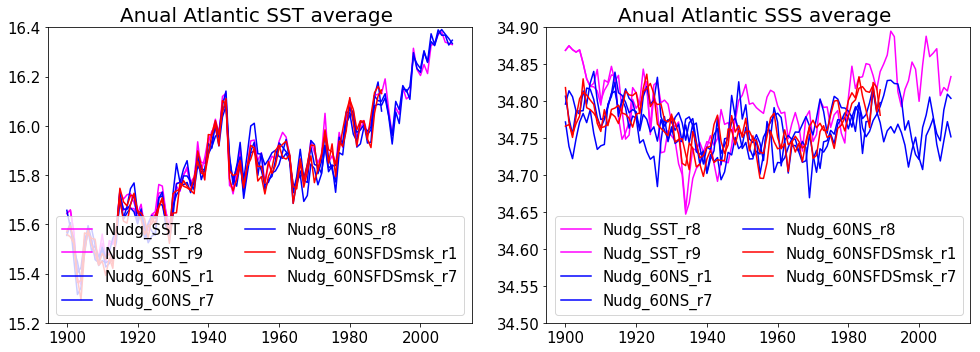

In [61]:
#Average = np.zeros((nmodels,Aarea.shape[1],Aarea.shape[2]))
plt.close()
fig, axes = plt.subplots(1,2,figsize=(2*7,5))
for imodel in range(nmodels):        
    dir1 = Models[imodel]['dir']+Models[imodel]['name']+'/OCE/Analyse/'+Models[imodel]['TS']
    os.chdir(dir1)
    file1 = glob.glob('*_tos.nc')
    
    f = Dataset(file1[0],'r')
    for time in range(0,Models[imodel]['yr1']-Models[imodel]['yr0']):
        tab=np.array(f.variables['tos'][Models[imodel]['ts0']+time*12:Models[imodel]['ts0']+12*(time+1),:,:])
        mask_tab=np.zeros((tab.shape[0],tab.shape[1],tab.shape[2]))
        mask_tab[ma.where(tab>1.e10)]=1. 
        tab_masked=ma.masked_where(mask_tab ==1., tab)
        tab_masked_temp=np.reshape(tab_masked,(12,tab_masked.shape[0]/12,tab_masked.shape[1],tab_masked.shape[2]),order='F')
        tab_masked_ann=ma.average(tab_masked_temp,axis=0)
    
        if time ==0:
            Average = ma.average(tab_masked_ann[:,:,:], axis=(1,2), weights = Aarea[:1,:,:])
        else:
            Average = ma.concatenate([Average, ma.average(tab_masked_ann[:,:,:], axis=(1,2), weights =Aarea[:1,:,:])], axis=0)
    
    axes[0].plot(np.arange(Models[imodel]['yr0'], Models[imodel]['yr1']),Average,color =Models[imodel]['color'], label=Models[imodel]['label']  )
    

    
    file1 = glob.glob('*_sos.nc')
    
    f = Dataset(file1[0],'r')
    for time in range(0,Models[imodel]['yr1']-Models[imodel]['yr0']):
        tab=np.array(f.variables['sos'][Models[imodel]['ts0']+time*12:Models[imodel]['ts0']+12*(time+1),:,:])
        mask_tab=np.zeros((tab.shape[0],tab.shape[1],tab.shape[2]))
        mask_tab[ma.where(tab>1.e10)]=1. 
        tab_masked=ma.masked_where(mask_tab ==1., tab)
        tab_masked_temp=np.reshape(tab_masked,(12,tab_masked.shape[0]/12,tab_masked.shape[1],tab_masked.shape[2]),order='F')
        tab_masked_ann=ma.average(tab_masked_temp,axis=0)
    
        if time ==0:
            Average = ma.average(tab_masked_ann[:,:,:], axis=(1,2), weights = Aarea[:1,:,:])
        else:
            Average = ma.concatenate([Average, ma.average(tab_masked_ann[:,:,:], axis=(1,2), weights =Aarea[:1,:,:])], axis=0)
    
    axes[1].plot(np.arange(Models[imodel]['yr0'], Models[imodel]['yr1']),Average,color =Models[imodel]['color'], label=Models[imodel]['label']  )
    
axes[1].set_title("Anual Atlantic SSS average " , fontsize=20)
axes[1].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].set_ylim((34.5,34.9))

axes[0].set_title("Anual Atlantic SST average " , fontsize=20)
axes[0].tick_params(axis='y', labelsize=15)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].set_ylim((15.2,16.4))

axes[0].legend(loc=4,ncol=2, fontsize=15)
axes[1].legend(loc=4,ncol=2, fontsize=15)
plt.tight_layout()
plt.show()


# AMOC

In [68]:
imodel = 0
dir1 = Models[imodel]['dir']+Models[imodel]['name']+'/OCE/Analyse/'+Models[imodel]['TS']+'/'
os.chdir(dir1)

file1 = glob.glob('*_zomsfatl.nc')

f = Dataset(file1[0],'r')

tab=np.squeeze(f.variables['zomsfatl'][Models[imodel]['ts0']:Models[imodel]['ts1'],:,:])


depthw = f.variables['olevel'][:]
lat = f.variables['nav_lat'][:]

In [69]:
lat[228], lat[255]

(array([ 26.056036], dtype=float32), array([ 47.82899094], dtype=float32))

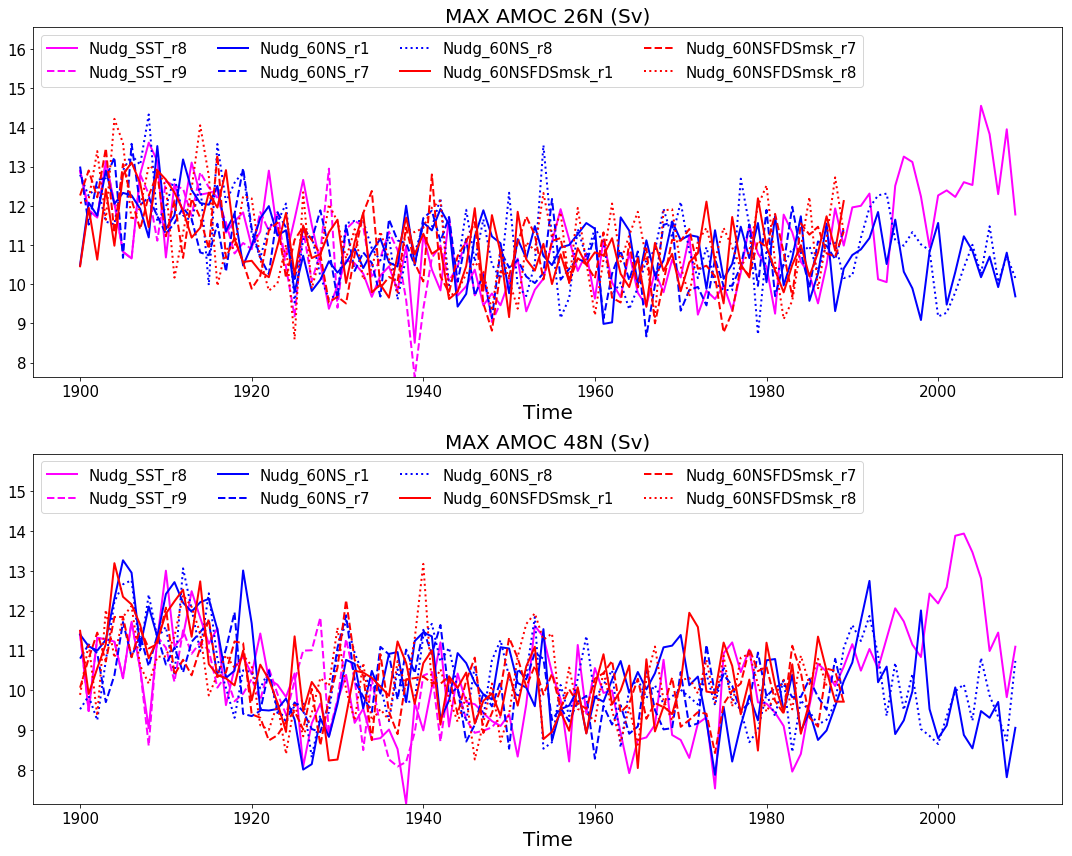

In [73]:
Max =0 
Min =35

Max2 =0 
Min2 =35

plt.close()
fig, axes = plt.subplots(2,1,figsize=(15,12))


for imodel in range(nmodels):

    ## AMOC

    dir1 = Models[imodel]['dir']+Models[imodel]['name']+'/OCE/Analyse/'+Models[imodel]['TS']+'/'
    os.chdir(dir1)
    
    file1 = glob.glob('*_zomsfatl.nc')
    
    f = Dataset(file1[0],'r')

    
    tab=np.squeeze(f.variables['zomsfatl'][Models[imodel]['ts0']:Models[imodel]['ts1'],:,:])
    
    length =tab.shape[0]
    # apply mask
    mask_zomsfatl=np.zeros((tab.shape[0],tab.shape[1],tab.shape[2]))
    mask_zomsfatl[:,:,ma.where(lat<10)]=1.
    mask_zomsfatl[:,:,ma.where(lat>60)]=1.
    mask_zomsfatl[:,ma.where(depthw<500),:]=1.
    mask_zomsfatl[ma.where(tab==0)]=1.
    
    # mask array
    tab_masked=np.ma.array(tab, mask=mask_zomsfatl)

    # look for maximum
    tab_masked_temp=np.reshape(tab_masked,(tab_masked.shape[0],tab_masked.shape[1]*tab_masked.shape[2]),order='F')
    max_amoc=ma.max(tab_masked_temp,axis=1)

    # annual mean
    tab_masked_temp=np.reshape(tab_masked,(12,tab_masked.shape[0]/12,tab_masked.shape[1],tab_masked.shape[2]),order='F')
    tab_masked_ann=ma.mean(tab_masked_temp,axis=0)
    max_amoc=ma.max(tab_masked_ann[:,:,228],axis=1)
    

    if ma.max( max_amoc)>Max:
        Max=ma.max( max_amoc)
    if ma.min( max_amoc)<Min:
        Min=ma.min( max_amoc)


        
    axes[0].plot(np.arange(Models[imodel]['yr0'],Models[imodel]['yr1']),max_amoc, color=Models[imodel]['color'],
                 ls=Models[imodel]['ls'], label = Models[imodel]['label'] , lw=Models[imodel]['lw'])


            
    axes[0].legend(loc=2, fontsize=15, ncol =4)
    axes[0].set_title("MAX AMOC 26N (Sv)", fontsize=20)
    axes[0].set_xlabel("Time", fontsize=20)
    axes[0].tick_params(axis='y', labelsize=15)
    axes[0].tick_params(axis='x', labelsize=15)
    axes[0].set_ylim([Min, Max+2])

    
    max_amoc=ma.max(tab_masked_ann[:,:,255],axis=1)
    

    if ma.max( max_amoc)>Max2:
        Max2=ma.max( max_amoc)
    if ma.min( max_amoc)<Min2:
        Min2=ma.min( max_amoc)


        
    axes[1].plot(np.arange(Models[imodel]['yr0'],Models[imodel]['yr1']),max_amoc, color=Models[imodel]['color'],
                 ls=Models[imodel]['ls'], label = Models[imodel]['label'] , lw=Models[imodel]['lw'])


            
    axes[1].legend(loc=2, fontsize=15, ncol =4)
    axes[1].set_title("MAX AMOC 48N (Sv)", fontsize=20)
    axes[1].set_xlabel("Time", fontsize=20)
    axes[1].tick_params(axis='y', labelsize=15)
    axes[1].tick_params(axis='x', labelsize=15)
    axes[1].set_ylim([Min2, Max2+2])

    

plt.tight_layout()
plt.show()

# Rapid period

## Read AMOC data

In [109]:
loc="/data/vestella/Data/RAPID"
os.chdir(loc)
os.getcwd()
file2read1 = Dataset('moc_transports.nc','r')
AMOC_RAPID = np.array(file2read1.variables['moc_mar_hc10'])
time = np.array(file2read1.variables['time'])

In [155]:
months = [31,28,31,30,31,30,31,31,30,31,30,31]
months1 = [31,29,31,30,31,30,31,31,30,31,30,31]
RAPID = np.zeros(12*5+9)
RAPID_ann = np.zeros(6)
counter = 0
counter_month = 0
for year in range(6):
    if year ==0:
        for month in range(3,12):
            if month ==3:
                RAPID[counter_month]=np.average(AMOC_RAPID[counter+10:counter + months[month]*2])
            else:
                RAPID[counter_month]=np.average(AMOC_RAPID[counter:counter + months[month]*2])
            RAPID_ann[year] = RAPID_ann[year] + RAPID[counter_month]/9
            counter = counter + months[month]*2
            counter_month = counter_month+1
            

            
    elif year ==4:
        for month in range(12):
            RAPID[counter_month]=np.average(AMOC_RAPID[counter+10:counter + months1[month]*2])
            RAPID_ann[year] = RAPID_ann[year] + RAPID[counter_month]/12
            counter = counter + months1[month]*2
            counter_month = counter_month+1

    else:
        for month in range(12):
            RAPID[counter_month]=np.average(AMOC_RAPID[counter:counter + months1[month]*2])
            RAPID_ann[year] = RAPID_ann[year] + RAPID[counter_month]/12
            counter = counter + months1[month]*2
            counter_month = counter_month+1        
            

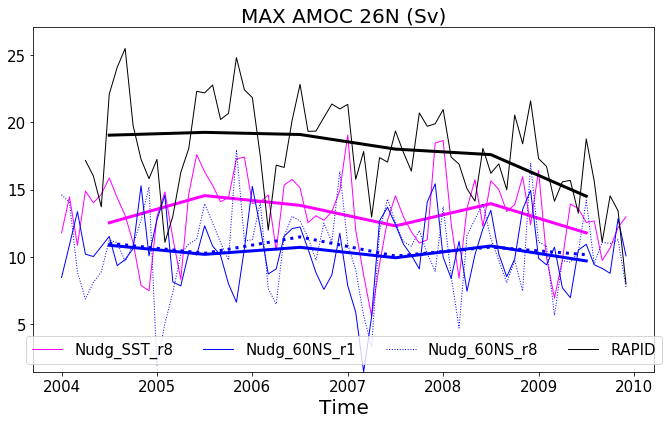

In [173]:
Max =0 
Min =35

Max2 =0 
Min2 =35

plt.close()
fig, axes = plt.subplots(1,1,figsize=(10,6))


for imodel in [0,2,4]:

    ## AMOC

    dir1 = Models[imodel]['dir']+Models[imodel]['name']+'/OCE/Analyse/'+Models[imodel]['TS']+'/'
    os.chdir(dir1)
    
    file1 = glob.glob('*_zomsfatl.nc')
    
    f = Dataset(file1[0],'r')
    depthw = f.variables['olevel'][:]
    lat = f.variables['nav_lat'][228]
    
    tab=np.squeeze(f.variables['zomsfatl'][104*12:,:,228])
    
    length =tab.shape[0]
    # apply mask
    mask_zomsfatl=np.zeros((tab.shape[0],tab.shape[1]))
    mask_zomsfatl[:,ma.where(depthw<500)]=1.
    mask_zomsfatl[ma.where(tab==0)]=1.
    
    # mask array
    tab_masked=np.ma.array(tab, mask=mask_zomsfatl)

    # look for maximum
    max_amoc=ma.max(tab_masked,axis=1)
    
    # annual mean
    tab_masked_temp=np.reshape(tab_masked,(12,tab_masked.shape[0]/12,tab_masked.shape[1]),order='F')
    tab_masked_ann=ma.mean(tab_masked_temp,axis=0)
    max_amoc_ann=ma.max(tab_masked_ann[:,:],axis=1)


    if ma.max( max_amoc)>Max:
        Max=ma.max( max_amoc)
    if ma.min( max_amoc)<Min:
        Min=ma.min( max_amoc)


        
    axes.plot(max_amoc, color=Models[imodel]['color'],ls=Models[imodel]['ls'], label = Models[imodel]['label'] , 
              lw=1)
    axes.plot(np.arange(0,72,12)+6, max_amoc_ann, color=Models[imodel]['color'],ls=Models[imodel]['ls'], 
              lw=3)


            


axes.plot(np.arange(3,72),RAPID, color = 'k',label='RAPID', lw=1)
axes.plot(np.arange(0,72,12)+6,RAPID_ann, color = 'k', lw=3)

axes.legend(loc=8, fontsize=15, ncol =4)
axes.set_title("MAX AMOC 26N (Sv)", fontsize=20)
axes.set_xlabel("Time", fontsize=20)
axes.tick_params(axis='y', labelsize=15)
axes.tick_params(axis='x', labelsize=15)
axes.set_xticks(np.arange(0,73,12))
axes.set_xticklabels(np.arange(2004, 2011))
axes.set_ylim([Min, Max+8])
plt.tight_layout()
plt.show()

In [93]:
max_amoc_ann.shape, tab_masked_temp.shape, tab_masked.shape

((6,), (12, 6, 75), (72, 75))

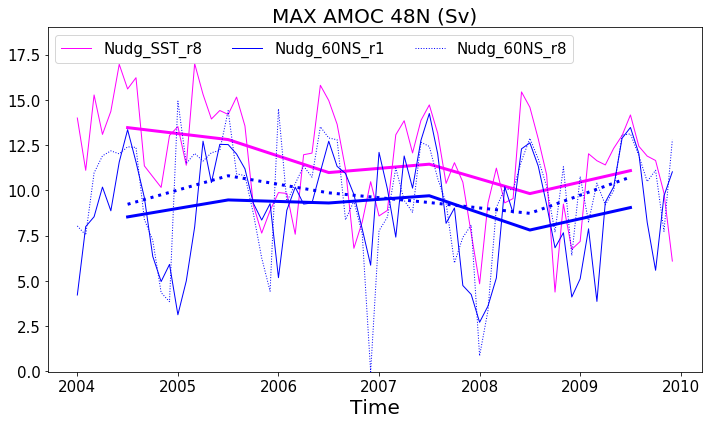

In [101]:
Max =0 
Min =35

Max2 =0 
Min2 =35

plt.close()
fig, axes = plt.subplots(1,1,figsize=(10,6))


for imodel in [0,2,4]:

    ## AMOC

    dir1 = Models[imodel]['dir']+Models[imodel]['name']+'/OCE/Analyse/'+Models[imodel]['TS']+'/'
    os.chdir(dir1)
    
    file1 = glob.glob('*_zomsfatl.nc')
    
    f = Dataset(file1[0],'r')
    depthw = f.variables['olevel'][:]
    lat = f.variables['nav_lat'][228]
    
    tab=np.squeeze(f.variables['zomsfatl'][104*12:,:,255])
    
    length =tab.shape[0]
    # apply mask
    mask_zomsfatl=np.zeros((tab.shape[0],tab.shape[1]))
    mask_zomsfatl[:,ma.where(depthw<500)]=1.
    mask_zomsfatl[ma.where(tab==0)]=1.
    
    # mask array
    tab_masked=np.ma.array(tab, mask=mask_zomsfatl)

    # look for maximum
    max_amoc=ma.max(tab_masked,axis=1)
    
    # annual mean
    tab_masked_temp=np.reshape(tab_masked,(12,tab_masked.shape[0]/12,tab_masked.shape[1]),order='F')
    tab_masked_ann=ma.mean(tab_masked_temp,axis=0)
    max_amoc_ann=ma.max(tab_masked_ann[:,:],axis=1)


    if ma.max( max_amoc)>Max:
        Max=ma.max( max_amoc)
    if ma.min( max_amoc)<Min:
        Min=ma.min( max_amoc)


        
    axes.plot(max_amoc, color=Models[imodel]['color'],ls=Models[imodel]['ls'], label = Models[imodel]['label'] , 
              lw=1)
    axes.plot(np.arange(0,72,12)+6, max_amoc_ann, color=Models[imodel]['color'],ls=Models[imodel]['ls'], 
              lw=3)


            
axes.legend(loc=2, fontsize=15, ncol =4)
axes.set_title("MAX AMOC 48N (Sv)", fontsize=20)
axes.set_xlabel("Time", fontsize=20)
axes.tick_params(axis='y', labelsize=15)
axes.tick_params(axis='x', labelsize=15)
axes.set_xticks(np.arange(0,73,12))
axes.set_xticklabels(np.arange(2004, 2011))
axes.set_ylim([Min, Max+2])



plt.tight_layout()
plt.show()

# Anomalies

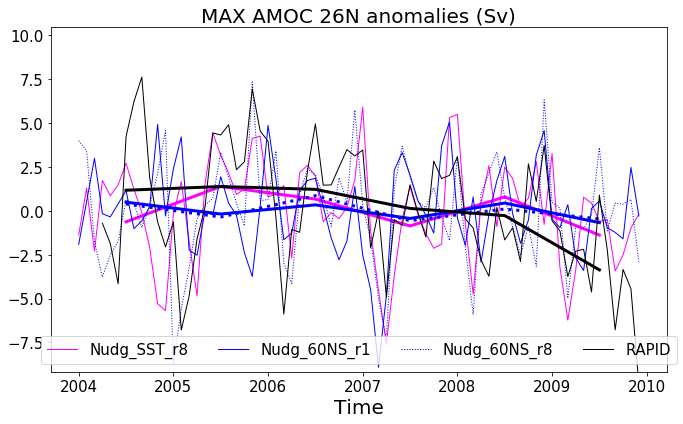

In [176]:
Max =0 
Min =35

plt.close()
fig, axes = plt.subplots(1,1,figsize=(10,6))


for imodel in [0,2,4]:

    ## AMOC

    dir1 = Models[imodel]['dir']+Models[imodel]['name']+'/OCE/Analyse/'+Models[imodel]['TS']+'/'
    os.chdir(dir1)
    
    file1 = glob.glob('*_zomsfatl.nc')
    
    f = Dataset(file1[0],'r')
    depthw = f.variables['olevel'][:]
    lat = f.variables['nav_lat'][228]
    
    tab=np.squeeze(f.variables['zomsfatl'][104*12:,:,228])
    
    length =tab.shape[0]
    # apply mask
    mask_zomsfatl=np.zeros((tab.shape[0],tab.shape[1]))
    mask_zomsfatl[:,ma.where(depthw<500)]=1.
    mask_zomsfatl[ma.where(tab==0)]=1.
    
    # mask array
    tab_masked=np.ma.array(tab, mask=mask_zomsfatl)

    # look for maximum
    max_amoc=ma.max(tab_masked,axis=1)
    
    # annual mean
    tab_masked_temp=np.reshape(tab_masked,(12,tab_masked.shape[0]/12,tab_masked.shape[1]),order='F')
    tab_masked_ann=ma.mean(tab_masked_temp,axis=0)
    max_amoc_ann=ma.max(tab_masked_ann[:,:],axis=1)


    if ma.max( max_amoc)>Max:
        Max=ma.max( max_amoc)
    if ma.min( max_amoc)<Min:
        Min=ma.min( max_amoc)


    mean = ma.mean(max_amoc)
    axes.plot(max_amoc-mean, color=Models[imodel]['color'],ls=Models[imodel]['ls'], label = Models[imodel]['label'] , 
              lw=1)
    axes.plot(np.arange(0,72,12)+6, max_amoc_ann-mean, color=Models[imodel]['color'],ls=Models[imodel]['ls'], 
              lw=3)

axes.plot(np.arange(3,72),RAPID - ma.average(RAPID), color = 'k',label='RAPID', lw=1)
axes.plot(np.arange(0,72,12)+6,RAPID_ann- ma.average(RAPID), color = 'k', lw=3)
            
axes.legend(loc=8, fontsize=15, ncol =4)
axes.set_title("MAX AMOC 26N anomalies (Sv)", fontsize=20)
axes.set_xlabel("Time", fontsize=20)
axes.tick_params(axis='y', labelsize=15)
axes.tick_params(axis='x', labelsize=15)
axes.set_xticks(np.arange(0,73,12))
axes.set_xticklabels(np.arange(2004, 2011))
axes.set_ylim([Min-mean, Max+2-mean])



plt.tight_layout()
plt.show()